<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/effB2_FoodViz_tinkering_v003_effB2_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TL;DR ### ***NEED TO UPDATE W/ 2025-10-24 EXPERIMENTS!!!***

- I applied another version of eff -> EfficientNet_B2 to our same model, with minor tweaks to support this version of the EfficientNet pre-trained model, with the expectation, test accuracy would have some minor improvements, which did occur.

- *However* ... - when looking at the probabilities in the labels, the B0 probabilities performed *much* better on correct labeling - e.g., the correct labels had higher probabilities assigned to the correct label (and B0 got ALL correct on the unseen random images, whereas B2 incorrectly labeled one...) Hence, it could be argued that B0 - all things being equal - in addition to performing better, on labels in which it classified the same as B2, B0 was *more* correct.


<!-- For update -->

<!-- Observations
Experiment 1 (2025-10-22)

In comparing EfficientNetB2 vs EfficientNetB0 performance, the B2 was only fractionally better in test data - BUT - when looking at the probabilities in the labels, the B0 probabilities were much better on correct labeling (hence, it could be argued that B0 - all things being equal - was more correct.)
Experiment 2 (2025-10-24)

I found some errors in my code which led to some incorrect img processing and discovered when I ran the unseen images, I had code in my eval loop which reverted the model back to pretrained weights (and base model!) Hence, all the training was for nought...

Additionally (and earlier in the experiment, came to realize that my scheduler was not even included in the train loop, so my learning rate annealing was not even happening! This has been fixed, and the "marginal improvement in test data" went up significantly --- (testing today resulted in 93.333% and 92.000% test acc, respectively, which is a sizeable bump from the 88.000% from EfficientNetB0 and the previously erroneous 89.333% from our 2025-10-22 experiments with EfficientNetB2 (which was not lr adjusting!) -->

In [69]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary

import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer as timer
from tqdm import tqdm

import requests
import zipfile
from pathlib import Path
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [70]:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

print(device)

mps


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Load the data from the drive:

train_dir = "./data/pizza_steak_sushi/train/"
test_dir = "./data/pizza_steak_sushi/test/"

### EfficientNet_B2 ###

In [72]:
# Load EfficientNet with B2 pretrained weights

# weights_eff = models.EfficientNet_B0_Weights.IMAGENET1K_V1

weights_eff = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model_eff = models.efficientnet_b2(weights=weights_eff)
preprocess_eff = weights_eff.transforms()

In [73]:
# Use the preprocess transform for EfficientNet_B0 (preprocess_eff)

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess_eff
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess_eff
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=2
)

In [74]:
test_dataset.classes

['pizza', 'steak', 'sushi']

In [75]:
# EfficientNet_B2 model, class, device, criterion & optimizer instantiation

model = model_eff

# Number of classes (Pizza–Steak–Sushi)
num_classes = len(train_dataset.classes)  # should be 3

# Freeze all layers except classifier head
for param in model.parameters():
    param.requires_grad = False

# Replace the final classifier
# EfficientNet_B2 has model.classifier = Sequential(Dropout, Linear)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Move model to device
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

In [76]:
# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

# Lists to store metrics over epochs
train_losses = []
train_accuracies = []

# Since we already know it works well, just going with 20 epochs;)
epochs = 24

for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    # Compute metrics for this epoch
    train_loss = running_loss / total
    train_acc = correct / total * 100
    
    # lr scheduler
    scheduler.step()

    # Save metrics (so we can plot a loss/acc curve!)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
   # Print epoch metrics and current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}% | LR: {current_lr:.6f}")

  4%|█▉                                            | 1/24 [00:15<05:50, 15.23s/it]

Epoch 1/24 | Loss: 1.0258 | Acc: 47.5556% | LR: 0.001000


  8%|███▊                                          | 2/24 [00:29<05:28, 14.94s/it]

Epoch 2/24 | Loss: 0.8357 | Acc: 81.7778% | LR: 0.001000


 12%|█████▊                                        | 3/24 [00:44<05:10, 14.77s/it]

Epoch 3/24 | Loss: 0.7226 | Acc: 88.0000% | LR: 0.001000


 17%|███████▋                                      | 4/24 [00:59<04:53, 14.66s/it]

Epoch 4/24 | Loss: 0.6462 | Acc: 82.6667% | LR: 0.001000


 21%|█████████▌                                    | 5/24 [01:13<04:36, 14.57s/it]

Epoch 5/24 | Loss: 0.5623 | Acc: 86.2222% | LR: 0.000800


 25%|███████████▌                                  | 6/24 [01:27<04:20, 14.49s/it]

Epoch 6/24 | Loss: 0.5156 | Acc: 89.3333% | LR: 0.000800


 29%|█████████████▍                                | 7/24 [01:42<04:05, 14.44s/it]

Epoch 7/24 | Loss: 0.4796 | Acc: 90.6667% | LR: 0.000800


 33%|███████████████▎                              | 8/24 [01:56<03:50, 14.41s/it]

Epoch 8/24 | Loss: 0.4339 | Acc: 95.1111% | LR: 0.000800


 38%|█████████████████▎                            | 9/24 [02:11<03:37, 14.51s/it]

Epoch 9/24 | Loss: 0.4269 | Acc: 92.8889% | LR: 0.000800


 42%|██████████████████▊                          | 10/24 [02:25<03:23, 14.55s/it]

Epoch 10/24 | Loss: 0.4109 | Acc: 91.1111% | LR: 0.000640


 46%|████████████████████▋                        | 11/24 [02:40<03:09, 14.60s/it]

Epoch 11/24 | Loss: 0.3954 | Acc: 92.4444% | LR: 0.000640


 50%|██████████████████████▌                      | 12/24 [02:55<02:56, 14.74s/it]

Epoch 12/24 | Loss: 0.3561 | Acc: 94.6667% | LR: 0.000640


 54%|████████████████████████▍                    | 13/24 [03:11<02:46, 15.14s/it]

Epoch 13/24 | Loss: 0.3312 | Acc: 94.6667% | LR: 0.000640


 58%|██████████████████████████▎                  | 14/24 [03:26<02:30, 15.05s/it]

Epoch 14/24 | Loss: 0.3387 | Acc: 96.4444% | LR: 0.000640


 62%|████████████████████████████▏                | 15/24 [03:41<02:14, 14.97s/it]

Epoch 15/24 | Loss: 0.3678 | Acc: 92.4444% | LR: 0.000512


 67%|██████████████████████████████               | 16/24 [03:55<01:58, 14.86s/it]

Epoch 16/24 | Loss: 0.3463 | Acc: 94.2222% | LR: 0.000512


 71%|███████████████████████████████▉             | 17/24 [04:10<01:43, 14.85s/it]

Epoch 17/24 | Loss: 0.3235 | Acc: 93.7778% | LR: 0.000512


 75%|█████████████████████████████████▊           | 18/24 [04:25<01:29, 14.95s/it]

Epoch 18/24 | Loss: 0.3198 | Acc: 95.1111% | LR: 0.000512


 79%|███████████████████████████████████▋         | 19/24 [04:40<01:14, 14.97s/it]

Epoch 19/24 | Loss: 0.3125 | Acc: 94.6667% | LR: 0.000512


 83%|█████████████████████████████████████▌       | 20/24 [04:56<01:00, 15.07s/it]

Epoch 20/24 | Loss: 0.2910 | Acc: 96.4444% | LR: 0.000410


 88%|███████████████████████████████████████▍     | 21/24 [05:11<00:44, 14.99s/it]

Epoch 21/24 | Loss: 0.3044 | Acc: 95.1111% | LR: 0.000410


 92%|█████████████████████████████████████████▎   | 22/24 [05:25<00:29, 14.89s/it]

Epoch 22/24 | Loss: 0.2786 | Acc: 95.5556% | LR: 0.000410


 96%|███████████████████████████████████████████▏ | 23/24 [05:40<00:14, 14.83s/it]

Epoch 23/24 | Loss: 0.2808 | Acc: 93.7778% | LR: 0.000410


100%|█████████████████████████████████████████████| 24/24 [05:54<00:00, 14.79s/it]

Epoch 24/24 | Loss: 0.2506 | Acc: 96.8889% | LR: 0.000410


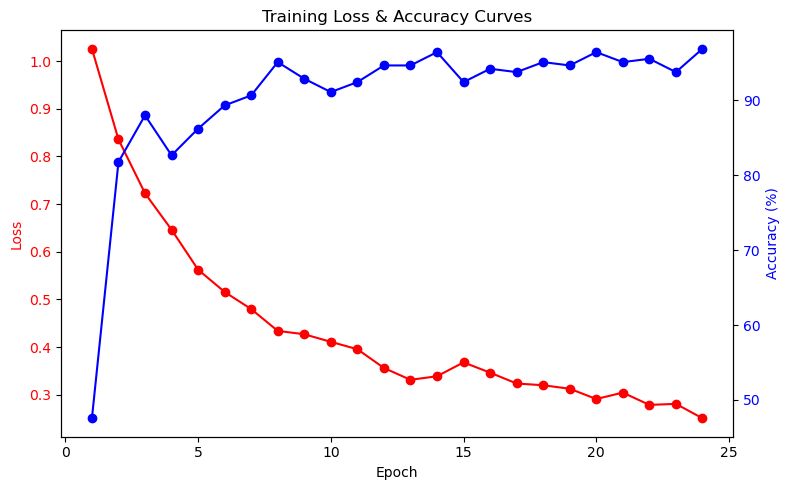

In [77]:
# --------------------------
# Plot Loss & Accuracy
# --------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot loss on left y-axis
ax1.plot(range(1, epochs+1), train_losses, color='red', marker='o', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), train_accuracies, color='blue', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and layout
plt.title('Training Loss & Accuracy Curves')
fig.tight_layout()
plt.show();

In [78]:
# Running Test Loop on EfficientNet

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.4f}%")

Test Accuracy: 92.0000%


In [79]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [80]:
train_loss, train_acc

(0.2505845398373074, 96.88888888888889)

***Save trained model***

In [81]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)  # creates it if it doesn't exist

# Add the current date to the filename
current_date = datetime.now().strftime("%Y%m%d")
model_save_path = os.path.join(save_dir, f"efficientnet_b2_pizza_steak_sushi_{current_date}_v002.pth")

In [82]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_pizza_steak_sushi_20251024_v002.pth


In [95]:
import os
from PIL import Image
import torch
from torchvision import models

# Folder containing unseen images (these are images of pizza/ steak/ sushi randomly grabbed fm the internet;)
folder_path = "./data/unseen_pza_stk_ssh"

# Make a list of image files
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
image_files.sort()

# Class names (same as your dataset)
class_names = ["pizza", "steak", "sushi"]

# Ensure the model is in evaluation mode
model.eval()
model = model.to(device)

# Actual predix on unseen imgs:

predicted_labels = []
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess_eff(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = class_names[probabilities.argmax()]
        predicted_labels.append(predicted_class)

    print(f"{img_name} → Predicted: {predicted_class}")

pizza_001.jpeg → Predicted: pizza
pizza_002.jpeg → Predicted: pizza
pizza_003.jpeg → Predicted: pizza
steak_001.jpeg → Predicted: steak
steak_002.jpeg → Predicted: steak
steak_003.jpeg → Predicted: steak
sushi_001.jpeg → Predicted: sushi
sushi_002.jpeg → Predicted: sushi
sushi_003.jpeg → Predicted: sushi


In [96]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(true_labels, predicted_labels))

Classification Report:

              precision    recall  f1-score   support

       pizza       1.00      1.00      1.00         3
       steak       1.00      1.00      1.00         3
       sushi       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Confusion Matrix:

[[3 0 0]
 [0 3 0]
 [0 0 3]]


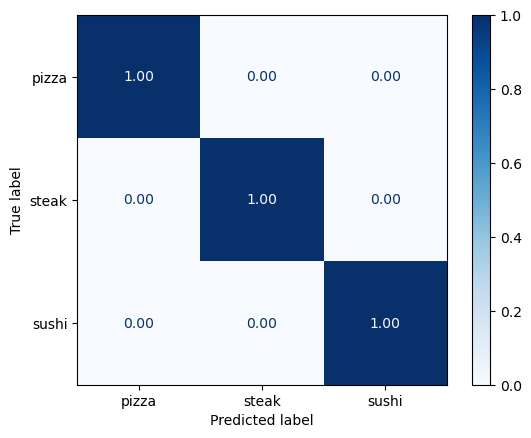

In [97]:
# ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    true_labels, predicted_labels
    , normalize="true", cmap="Blues"
)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.show();

In [60]:
import os
from PIL import Image
import torch
from torchvision import models
from matplotlib import pyplot as plt

In [98]:
# Updated predix function w/ probabilities displayed;

def show_image_prediction(img_path):
    # Load and preprocess
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess_eff(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        pred_idx = probabilities.argmax()
        pred_class = class_names[pred_idx]
        pred_prob = probabilities[pred_idx].item() * 100

    # Display image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} ({pred_prob:.2f}%)", fontsize=14, color='green')
    plt.show()

    # Print probability distribution below the image
    print("Class probabilities:")
    for i, cls in enumerate(class_names):
        prob = probabilities[i].item() * 100
        mark = "True" if i == pred_idx else "False"
        print(f"{mark} {cls:10s}: {prob:.4f}%")

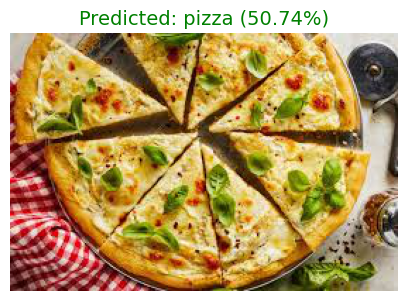

Class probabilities:
True pizza     : 50.7365%
False steak     : 17.2501%
False sushi     : 32.0134%


In [99]:
show_image_prediction(os.path.join(folder_path, image_files[0]))

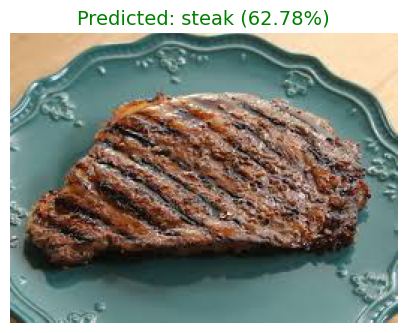

Class probabilities:
False pizza     : 18.9979%
True steak     : 62.7835%
False sushi     : 18.2186%


In [100]:
show_image_prediction(os.path.join(folder_path, image_files[3]))

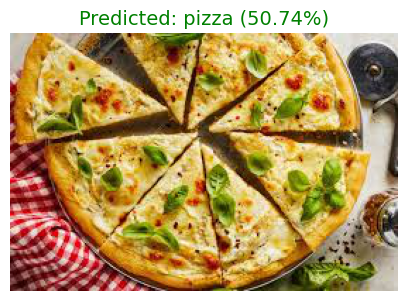

Class probabilities:
True pizza     : 50.7365%
False steak     : 17.2501%
False sushi     : 32.0134%


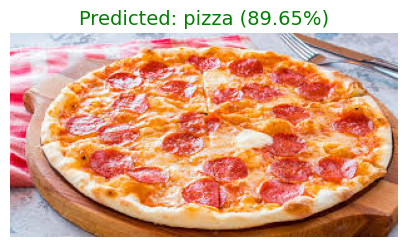

Class probabilities:
True pizza     : 89.6513%
False steak     : 4.8893%
False sushi     : 5.4594%


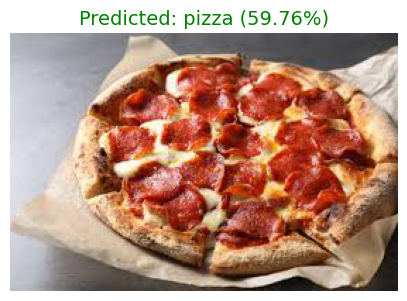

Class probabilities:
True pizza     : 59.7596%
False steak     : 18.2487%
False sushi     : 21.9917%


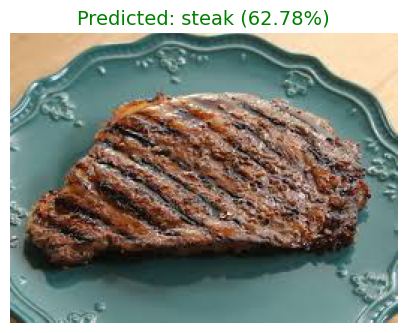

Class probabilities:
False pizza     : 18.9979%
True steak     : 62.7835%
False sushi     : 18.2186%


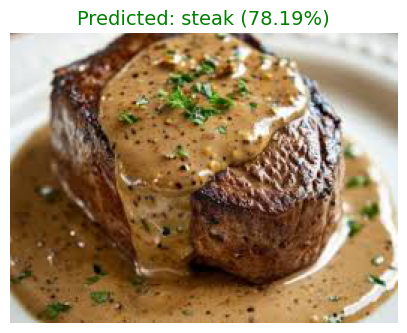

Class probabilities:
False pizza     : 12.9815%
True steak     : 78.1900%
False sushi     : 8.8285%


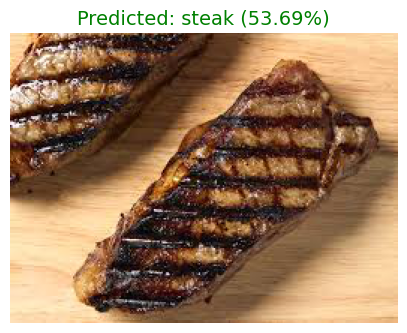

Class probabilities:
False pizza     : 22.7925%
True steak     : 53.6857%
False sushi     : 23.5218%


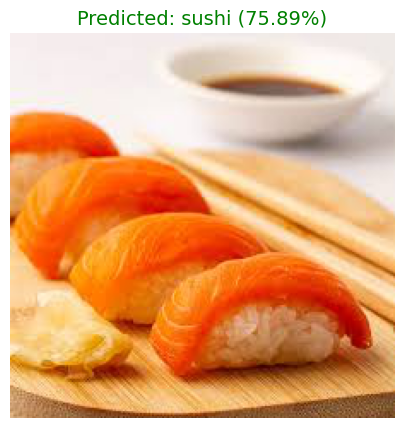

Class probabilities:
False pizza     : 9.0072%
False steak     : 15.1035%
True sushi     : 75.8893%


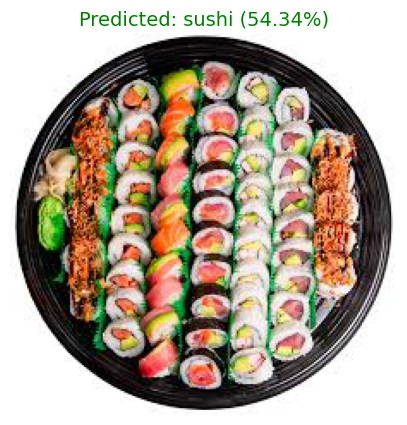

Class probabilities:
False pizza     : 24.1217%
False steak     : 21.5416%
True sushi     : 54.3367%


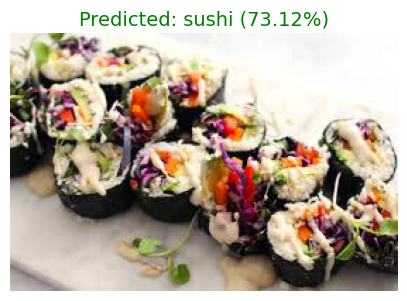

Class probabilities:
False pizza     : 15.1684%
False steak     : 11.7106%
True sushi     : 73.1210%


In [101]:
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    show_image_prediction(img_path)

In [27]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 288, 288])
labels.shape: torch.Size([32])


In [32]:
images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 25
single image shape: torch.Size([3, 288, 288])
single label: 2


In [33]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 0


### Observations ###

**Experiment 1 (2025-10-22)**

- In comparing EfficientNetB2 vs EfficientNetB0 performance, the B2 was only fractionally better in test data - BUT - when looking at the probabilities in the labels, the B0 probabilities were much better on correct labeling (hence, it could be argued that B0 - all things being equal - was *more* correct.)

**Experiment 2 (2025-10-24)**

- I found some errors in my code which led to some incorrect img processing and discovered when I ran the unseen images, I had code in my eval loop which reverted the model back to pretrained weights (and base model!) Hence, all the training was for nought... 

- Additionally (and earlier in the experiment, came to realize that my scheduler was not even included in the train loop, so my learning rate annealing was not even happening! This has been fixed, and the "marginal improvement in test data" went up significantly --- (testing today resulted in 93.333% and 92.000% test acc, respectively --> which is a sizeable bump from the 88.000% from EfficientNetB0 and the previously erroneous 89.333% from our 2025-10-22 experiments with EfficientNetB2 (which was not lr adjusting!)

In [102]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat